In [1]:
!pip install wget
!pip install transformers

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c52042199dda6f6750eebd9c48ce3bd7e68bee004e8b48d9ebd01974b587adf2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
!pip install tensorflow==2.16.1 tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalle

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",
              out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords
from helper_prabowo_ml import remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model

from transformers import AutoTokenizer, TFAutoModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_csv('spam_data.csv')
df

sms  label
0     Go until jurong point, crazy.. Available only ...      0
1                       Ok lar... Joking wif u oni...\n      0
2     Free entry in 2 a wkly comp to win FA Cup fina...      1
3     U dun say so early hor... U c already then say...      0
4     Nah I don't think he goes to usf, he lives aro...      0
...                                                 ...    ...
5569  This is the 2nd time we have tried 2 contact u...      1
5570             Will ü b going to esplanade fr home?\n      0
5571  Pity, * was in mood for that. So...any other s...      0
5572  The guy did some bitching but I acted like i'd...      0
5573                       Rofl. Its true to its name\n      0

[5574 rows x 2 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
df.shape

(5574, 2)

In [8]:
df.duplicated().sum()

403

In [9]:
df = df.drop_duplicates()
df.shape

(5171, 2)

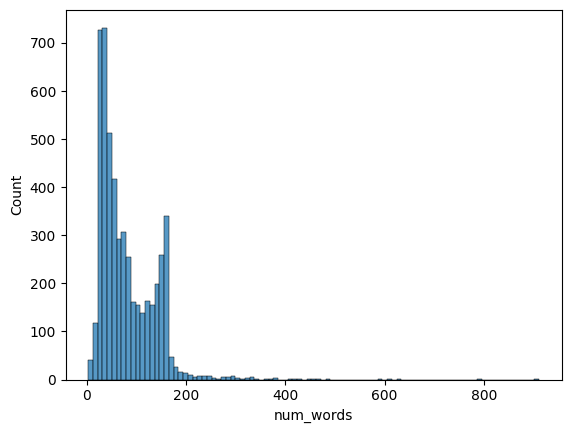

In [10]:
df['num_words'] = df.sms.apply(len)
sns.histplot(df.num_words);

In [11]:
df.describe()

label    num_words
count  5171.000000  5171.000000
mean      0.126281    80.332431
std       0.332198    58.333188
min       0.000000     3.000000
25%       0.000000    37.000000
50%       0.000000    62.000000
75%       0.000000   120.000000
max       1.000000   911.000000

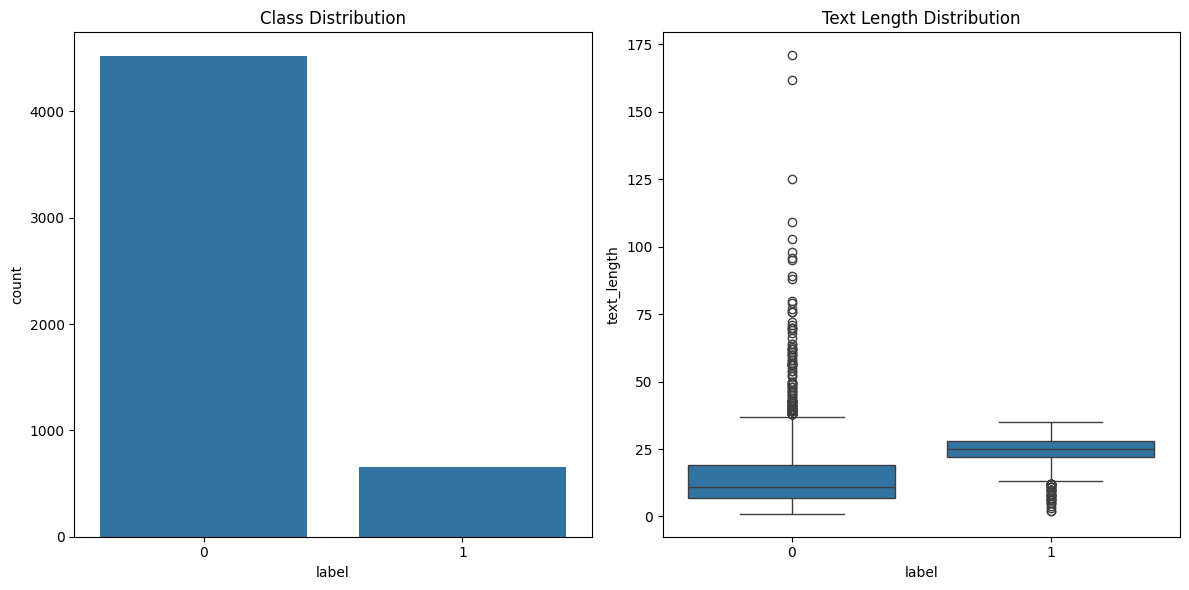

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df)
plt.title('Class Distribution')

plt.subplot(1, 2, 2)
df['text_length'] = df['sms'].apply(lambda x: len(x.split()))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length Distribution')

plt.tight_layout()
plt.show()

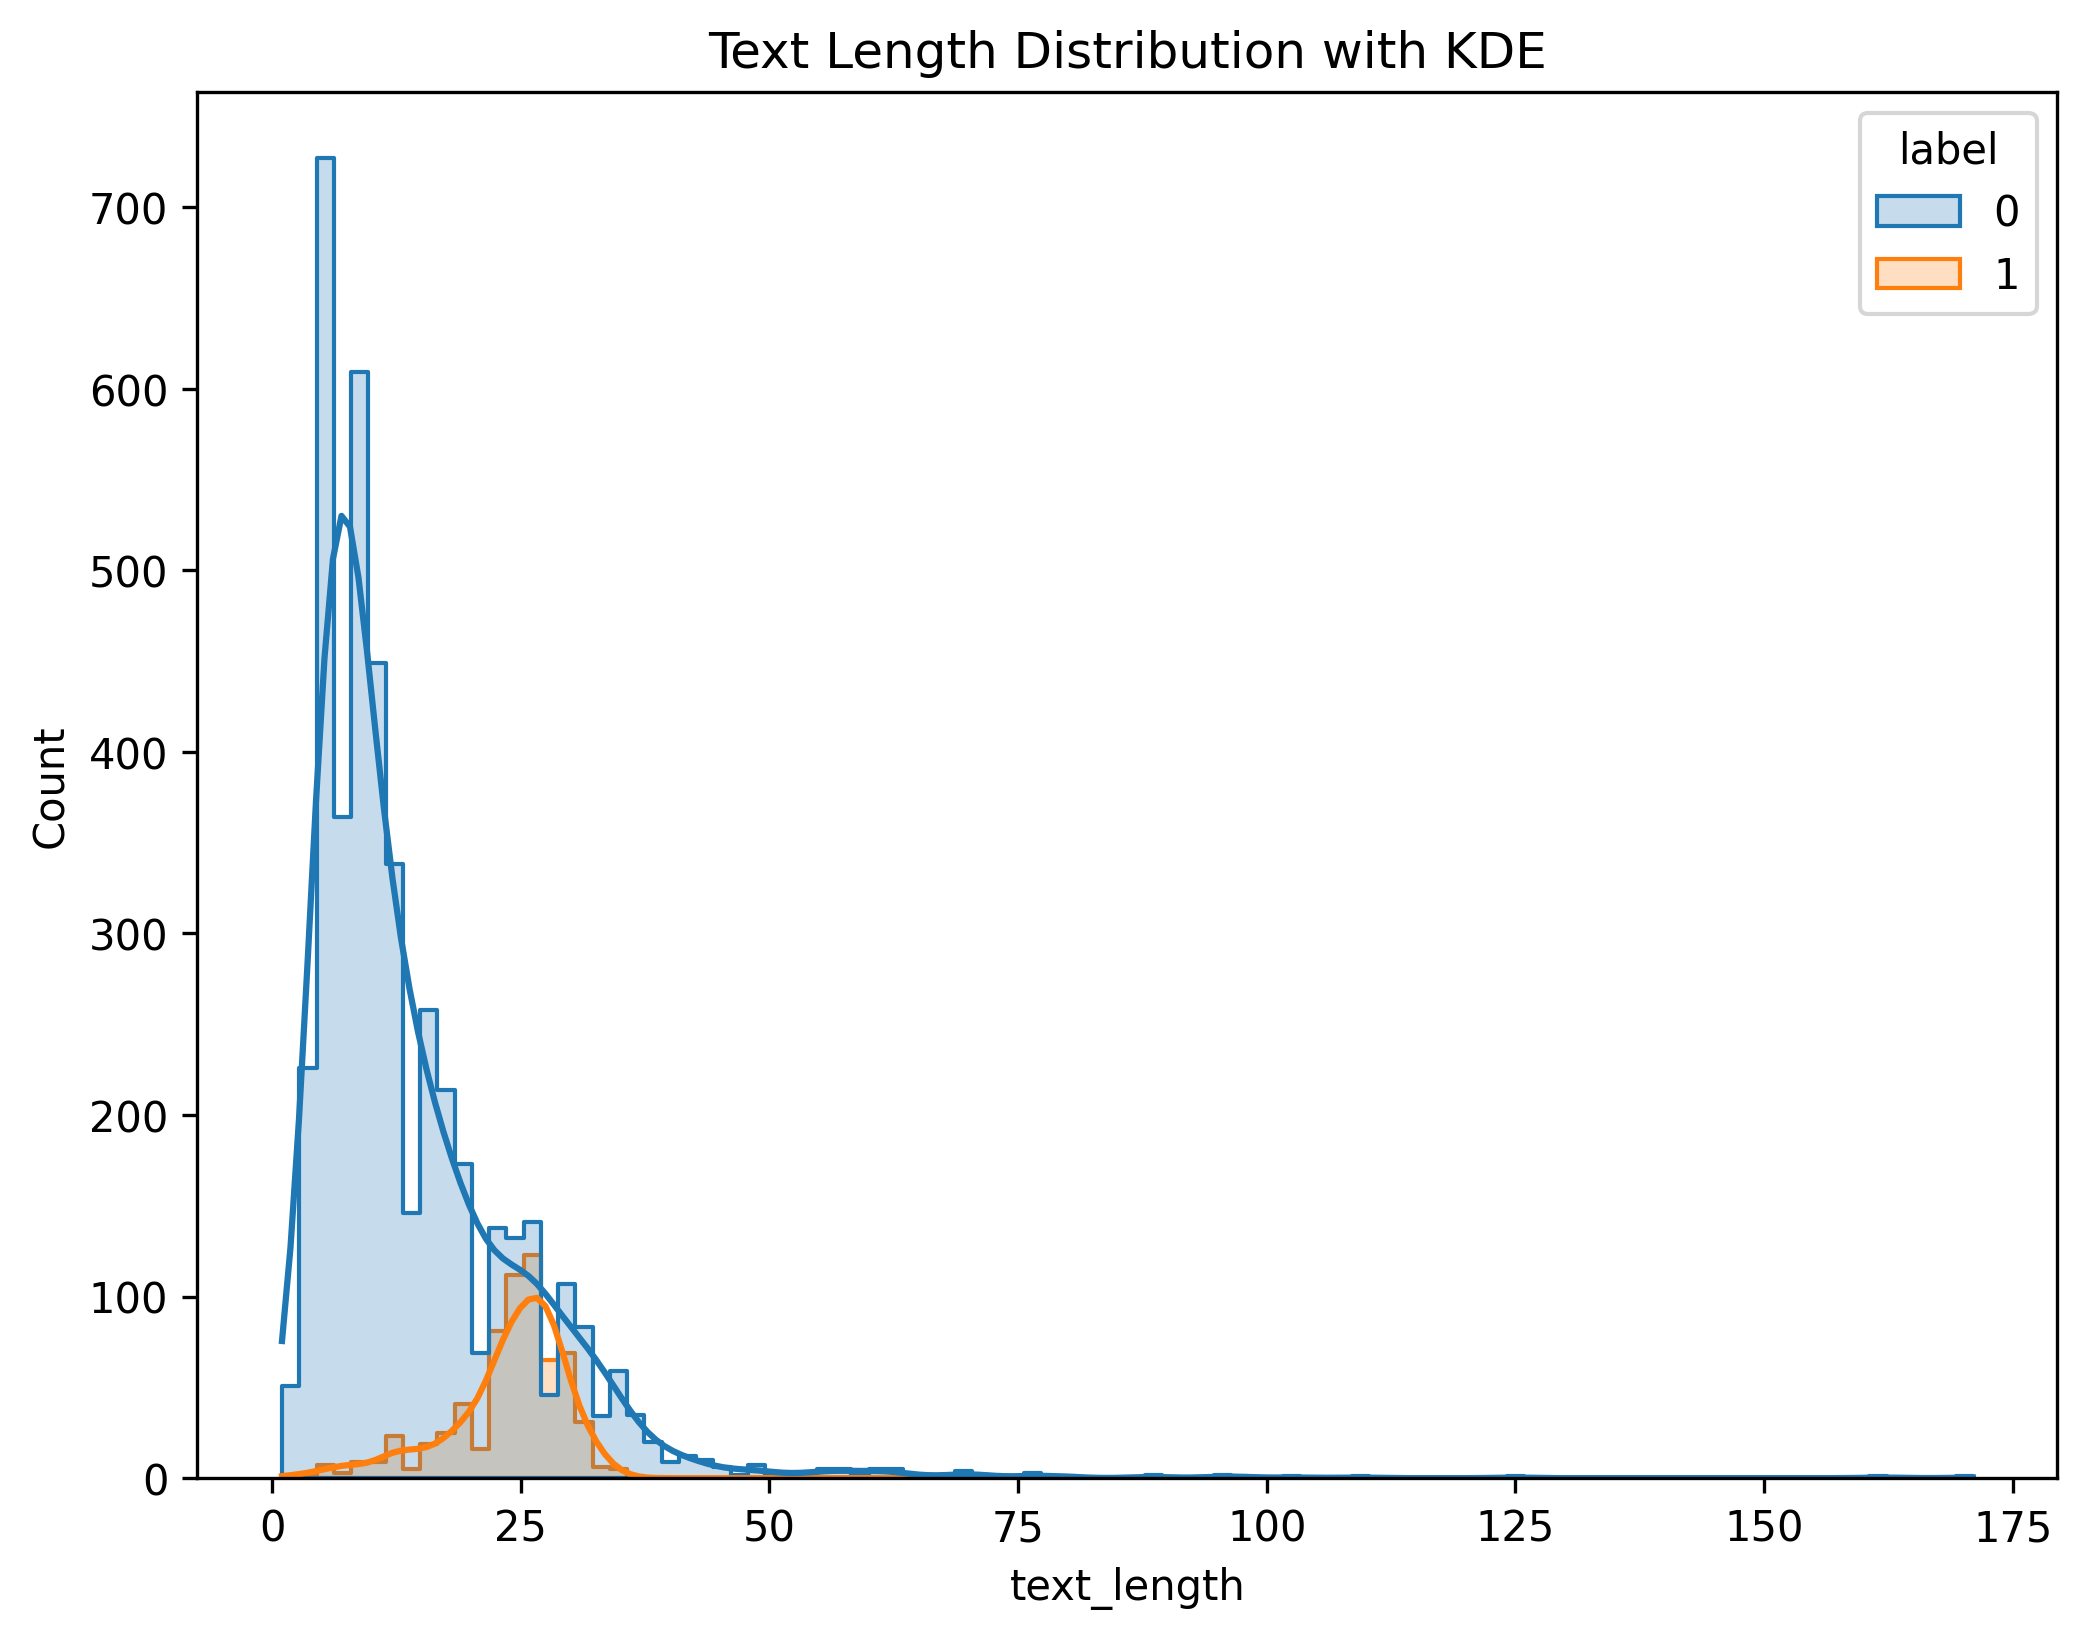

In [13]:
plt.figure(figsize=(8, 6), dpi=300)

sns.histplot(data=df, x='text_length', hue='label', kde=True, element='step')
plt.title('Text Length Distribution with KDE')

plt.show()

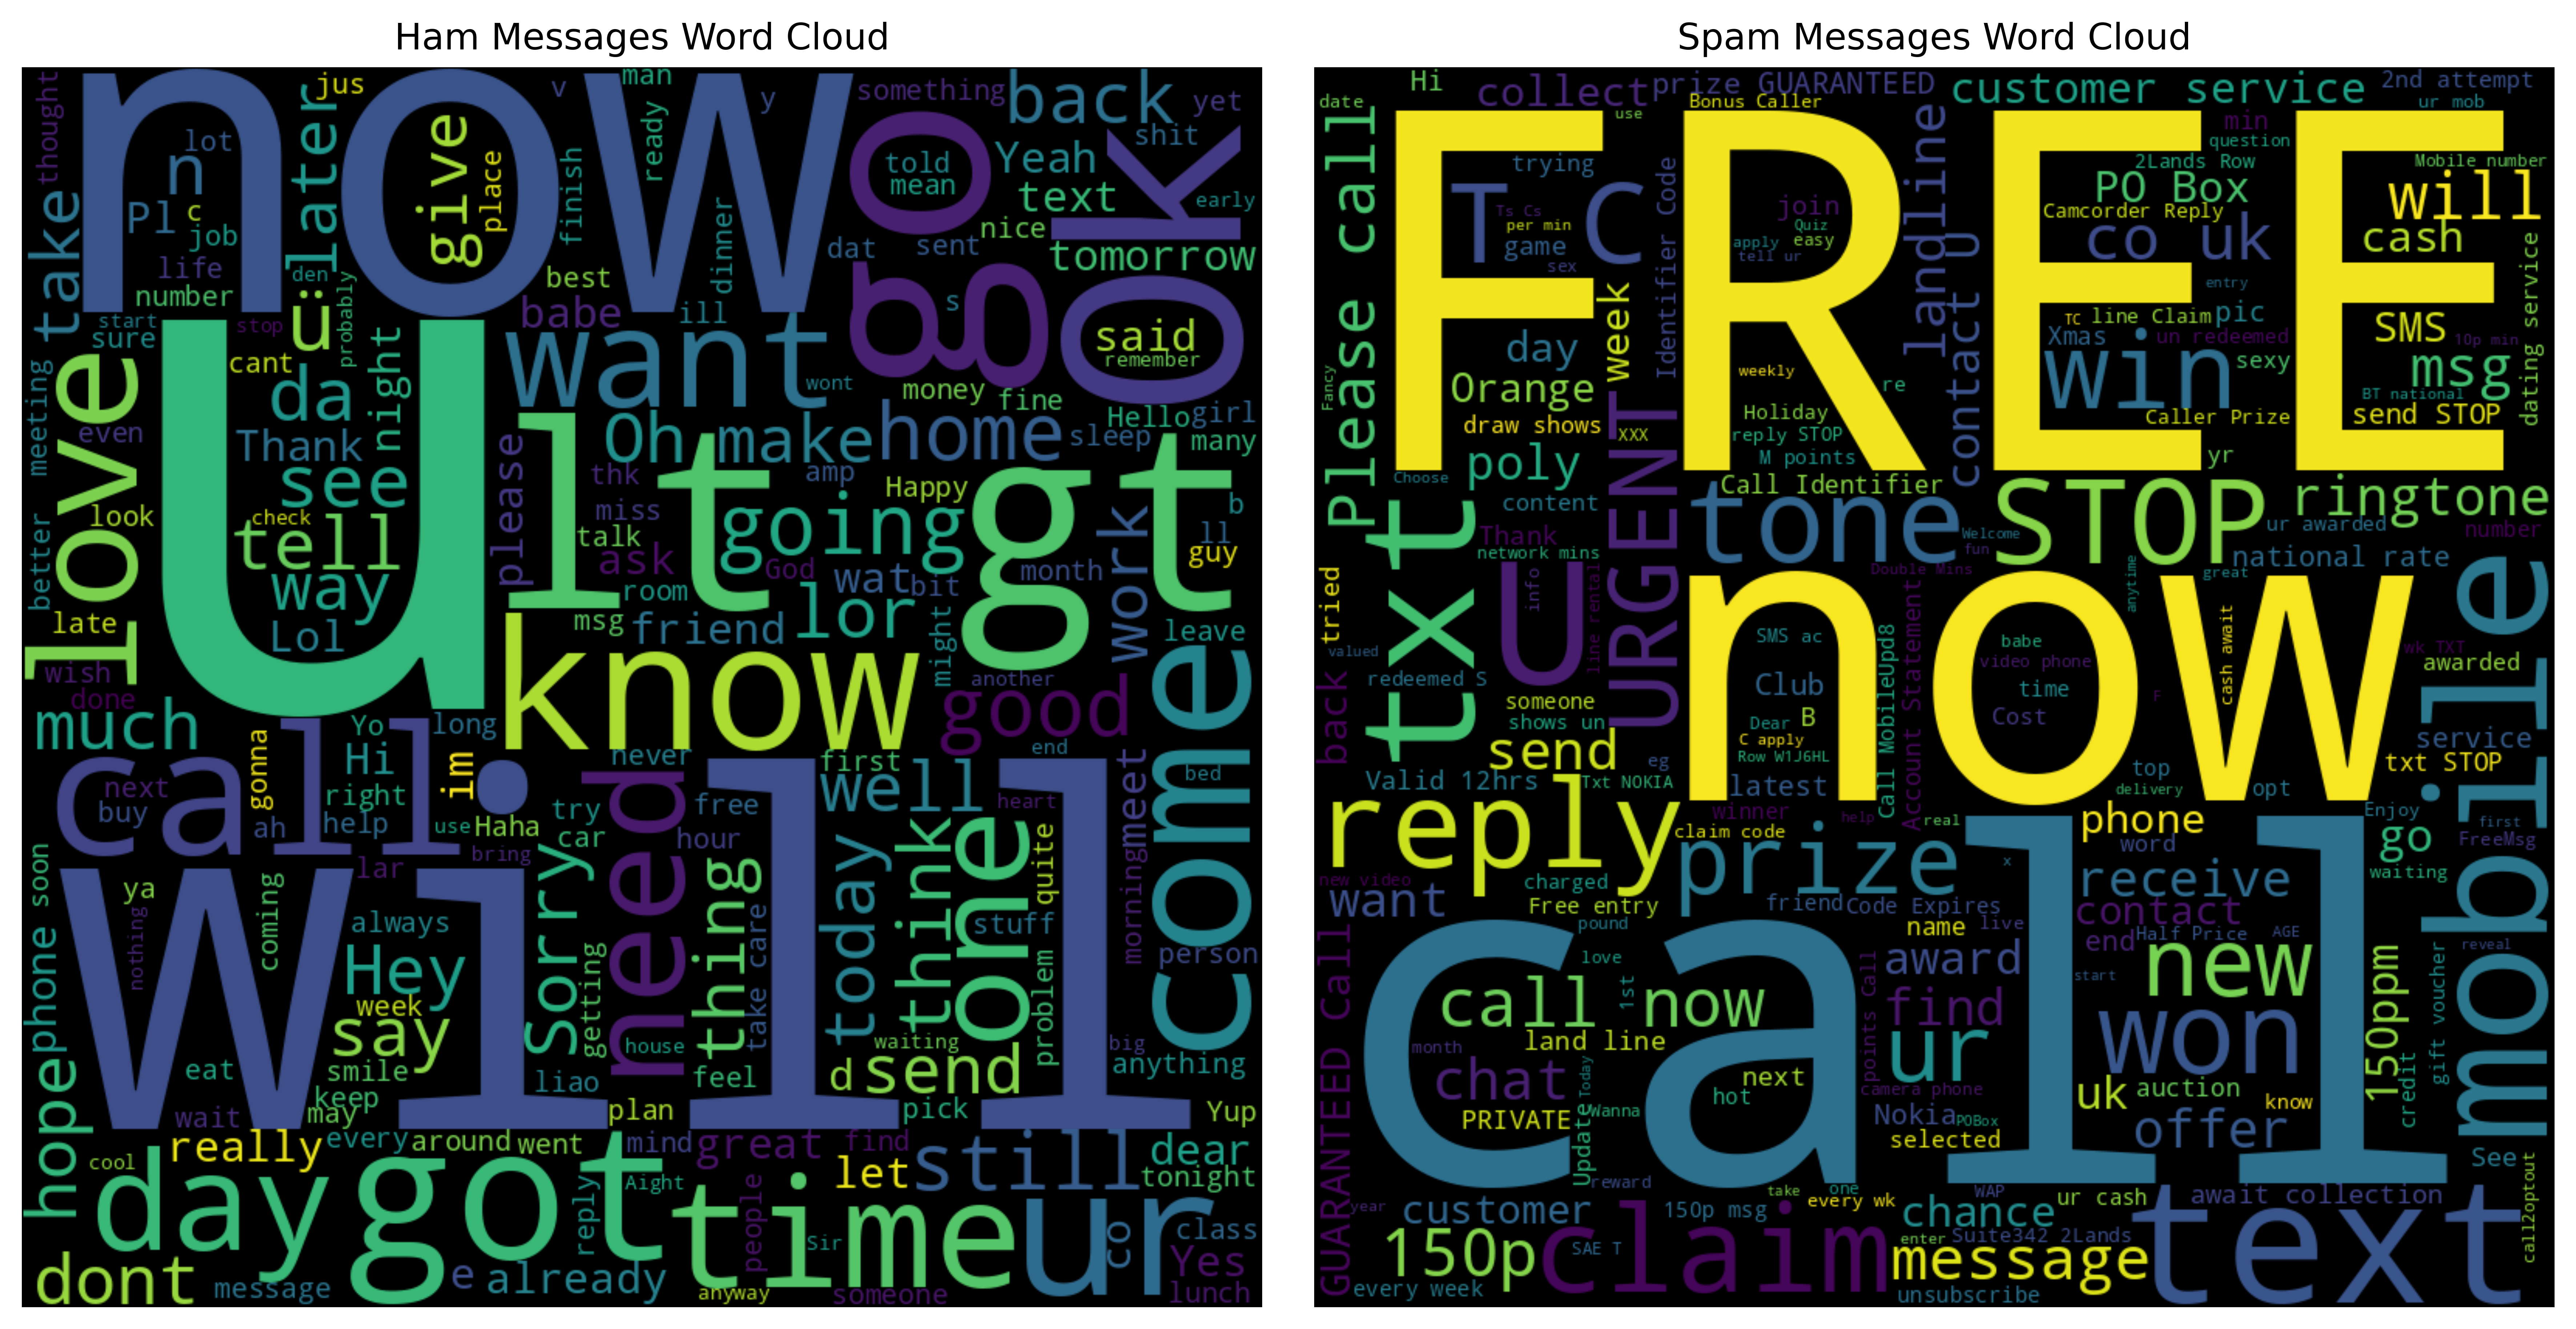

In [14]:
ham_text = " ".join(df[df['label'] == 0]['sms'])
spam_text = " ".join(df[df['label'] == 1]['sms'])

ham_wordcloud = WordCloud(width=800, height=800).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=600)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [16]:
preprocessed_df = text_preprocess(df,'sms')
preprocessed_df.head()

sms  label  num_words  \
0  go jurong point crazy available bugis n great ...      0        112   
1                            ok lar joking wif u oni      0         30   
2  free entry wkly comp win fa cup final tkts st ...      1        156   
3                u dun say early hor u c already say      0         50   
4             nah think goes usf lives around though      0         62   

   text_length  
0           20  
1            6  
2           28  
3           11  
4           13

In [17]:
preprocessed_df.drop(columns=['num_words', 'text_length'], axis=1, inplace=True)
preprocessed_df

sms  label
0     go jurong point crazy available bugis n great ...      0
1                               ok lar joking wif u oni      0
2     free entry wkly comp win fa cup final tkts st ...      1
3                   u dun say early hor u c already say      0
4                nah think goes usf lives around though      0
...                                                 ...    ...
5569  d time tried contact u u pound prize claim eas...      1
5570                     will b going esplanade fr home      0
5571                  pity mood that so any suggestions      0
5572  the guy bitching acted i d interested buying s...      0
5573                                 rofl its true name      0

[5171 rows x 2 columns]

In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
def extract_transformer_features(texts, max_length=128, batch_size=16): # Added batch processing
    """
    Extracts transformer features from a list of texts.
    """
    features = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i: i + batch_size]
        encodings = tokenizer(
            text=batch_texts,
            max_length=80,
            padding=True,
            truncation=True,
            return_tensors="tf",
            return_attention_mask=True,
            return_token_type_ids=False
        )
        outputs = model(encodings)
        batch_features = outputs.last_hidden_state[:, 0, :].numpy() # Convert to numpy array
        features.append(batch_features)

    return np.concatenate(features, axis=0) # Concatenate batches

X_train_transformer = extract_transformer_features(train_df.sms.tolist())
X_test_transformer = extract_transformer_features(test_df.sms.tolist())

In [22]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df.sms).toarray()
X_test_tfidf = vectorizer.transform(test_df.sms).toarray()

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_transformer_scaled = scaler.fit_transform(X_train_transformer)
X_test_transformer_scaled = scaler.transform(X_test_transformer)

X_train_combined = np.hstack((X_train_transformer_scaled, X_train_tfidf))
X_test_combined = np.hstack((X_test_transformer_scaled, X_test_tfidf))

y_train = train_df.label
y_test = test_df.label

In [28]:
model = MultinomialNB()
model.fit(X_train_combined, y_train)

y_pred = model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9527
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       898
           1       1.00      0.64      0.78       137

    accuracy                           0.95      1035
   macro avg       0.97      0.82      0.88      1035
weighted avg       0.96      0.95      0.95      1035



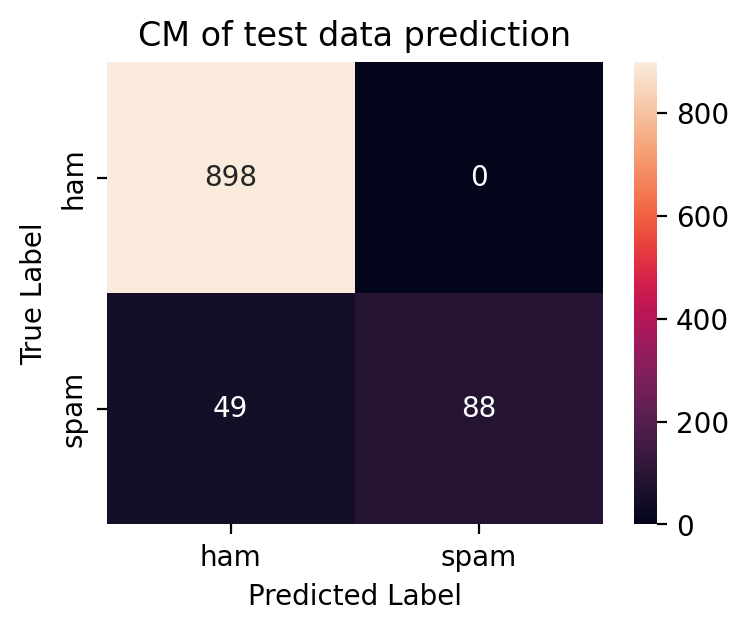

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('CM of test data prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()